#STEP 0: SETTING UP THE ENVIRONMENT

In [1]:
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

#STEP 1: DATA PREPARATION

## BagDataset Class
The `BagDataset` class is designed to create **bags** (representing WSIs) of  **instances** (representing patches) from the MNIST dataset.
  
Each bag:
  - Contains `bag_size × bag_size` instances (e.g., 8×8 = 64 digits per bag).
  - Is labeled as positive (`1`) if it contains at least one instance of a  specific digit (e.g., `1` for 'present'), and negative (`0`) otherwise.
  
#### Key Functions:
  - `__getitem__`: Generates a bag and assigns it a label based on the presence   of the target digit.
  - `_create_bag`: Combines individual instances into a grid-like image for   visualization.
  
#### Return:
The BagDataset Class returns a tuple with the following elements:
  - bag_image:
    - Type: `torch.Tensor`
    - Shape: `(bag_size*28, bag_size*28)`
    - Description: The tensor representing the grid-like image of the bag. Each   patch (MNIST digit image) from the bag is arranged into a larger grid with  dimensions determined by bag_size.
  - bag:
    - Type: `torch.Tensor`
    - Shape: `(patches_per_bag, 1, 28, 28)`
    - Description: The raw tensor of patches that make up the bag. Each patch   corresponds to an individual MNIST digit image, stored as a separate tensor   of shape `(1, 28, 28)` (grayscale single-channel image).
  - label:
    - Type: `int`
    - Value: either `0` or `1`
    - Description: The label of the bag. It indicates whether the bag contains a  positive patch `(label=1)` or consists entirely of negative patches `(label=0) `.
  
  This structure simplifies MIL, where the task is to classify bags instead of  individual instances.

In [2]:
class BagDataset(Dataset):
    def __init__(self, dataset, bag_size=8, positive_digit=1, negative_digit=0, seed=None):
        """
        Args:
            dataset: The MNIST dataset.
            bag_size: Number of instances along one dimension of the bag (e.g., 8 means 8x8 digit patches).
            positive_digit: The digit to include in positive bags.
            negative_digit: The digit to use for negative bags.
        """
        self.dataset = dataset
        self.bag_size = bag_size
        self.positive_digit = positive_digit
        self.negative_digit = negative_digit
        self.patches_per_bag = bag_size * bag_size

        self.positive_indices = [i for i, (_, label) in enumerate(dataset) if label == positive_digit]
        self.negative_indices = [i for i, (_, label) in enumerate(dataset) if label == negative_digit]

        self.dataset_images = torch.stack([data[0] for data in dataset], dim=0)
        self.dataset_labels = torch.tensor([data[1] for data in dataset])

        self.seed = seed

    def __len__(self):
        return len(self.dataset) // self.patches_per_bag

    def __getitem__(self, idx):

        if self.seed is not None:
            np.random.seed(self.seed + idx)
            torch.manual_seed(self.seed + idx)

        # Prepare bag
        if np.random.rand() > 0.5:
            # Positive bag
            bag_indices = np.random.choice(self.negative_indices, self.patches_per_bag - 1, replace=False).tolist()
            random_pos = np.random.randint(0, self.patches_per_bag)  # Random position for the positive digit
            bag_indices.insert(random_pos, np.random.choice(self.positive_indices))
            label = 1
        else:
            # Negative bag
            bag_indices = np.random.choice(self.negative_indices, self.patches_per_bag, replace=False).tolist()
            label = 0

        # Create a bag of digit patches
        bag = self.dataset_images[bag_indices]

        # Create a grid-like bag image for visualization
        bag_image = self._create_bag(bag)

        return bag_image, bag, label

    def _create_bag(self, patches):
        """
        Combine individual digit patches into a single bag image of shape
        (bag_size * 28, bag_size * 28), where 28x28 is the original shape of MNIST digits
        """
        bag_image = patches.view(self.bag_size, self.bag_size, 28, 28)
        bag_image = bag_image.permute(0, 2, 1, 3).contiguous()
        bag_image = bag_image.view(self.bag_size * 28, self.bag_size * 28)
        return bag_image

In [3]:
def worker_init_fn(worker_id):
    seed = SEED + worker_id
    np.random.seed(seed)
    torch.manual_seed(seed)

In [19]:
# Define bag_size
bag_size = 8

# Create train and test Datasets
train_dataset = BagDataset(datasets.MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)
test_dataset = BagDataset(datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True), bag_size=bag_size, seed=SEED)

# Create train and test DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, generator=torch.Generator().manual_seed(SEED), worker_init_fn=worker_init_fn)

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


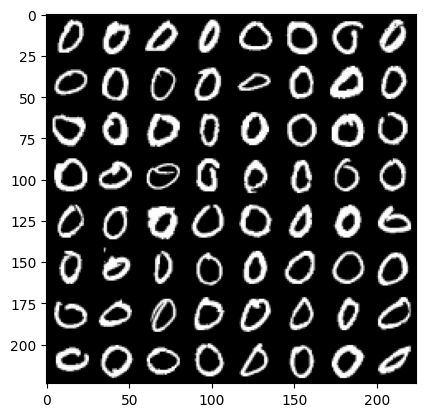

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


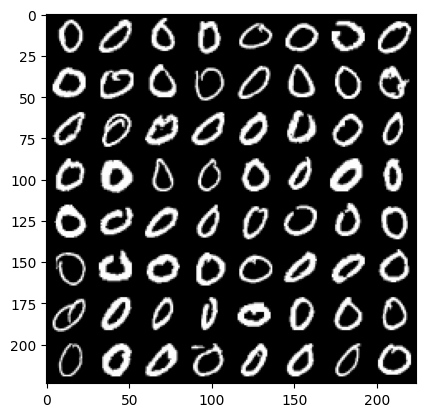

Bag label: 0
Bag shape: torch.Size([64, 1, 28, 28])


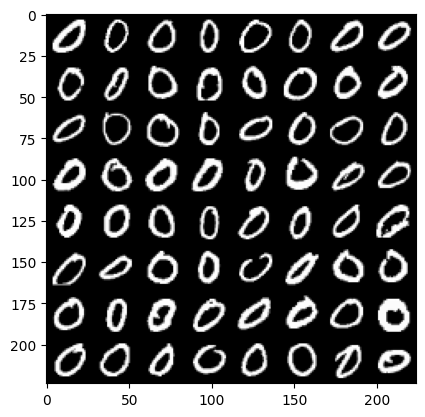

Bag label: 1
Bag shape: torch.Size([64, 1, 28, 28])


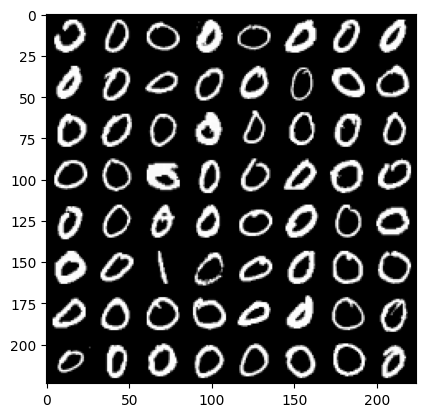

In [21]:
# Display example bags
for i, (bag_image, bag, label) in enumerate(train_loader):
  if i == 4:
    break
  print("Bag label:", label[0].item())
  print("Bag shape:", bag[0].shape)
  plt.imshow(bag_image[0].squeeze(), cmap='gray')
  plt.show()

#STEP 2: PATCH-LEVEL FEATURE EXTRACTION AND BAG-LEVEL FEATURE POOLING

###Feature Extractor definition
The Feature Extractor is designed to convert patch-level inputs into feature vectors.
  - INPUT: patch vector with shape `input_dims` (e.g., 784 for MNIST flattened 28×28 images).
  - OUTPUT: feature vector with shape `n_hidden` (e.g., 256 for the specific pre-trained model for MNIST classification)

In [22]:
from collections import OrderedDict
import torch.utils.model_zoo as model_zoo

model_urls = {
    'mnist': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth'
}

class Feature_Extractor(nn.Module):
    def __init__(self, input_dims, n_hiddens):
        super(Feature_Extractor, self).__init__()
        assert isinstance(input_dims, int), 'Please provide int for input_dims'
        self.input_dims = input_dims
        current_dims = input_dims
        layers = OrderedDict()

        if isinstance(n_hiddens, int):
            n_hiddens = [n_hiddens]
        else:
            n_hiddens = list(n_hiddens)
        for i, n_hidden in enumerate(n_hiddens):
            layers[f'fc{i+1}'] = nn.Linear(current_dims, n_hidden)
            layers[f'relu{i+1}'] = nn.ReLU()
            layers[f'drop{i+1}'] = nn.Dropout(0.2)
            current_dims = n_hidden

        self.model = nn.Sequential(layers)
        print(self.model)

    def forward(self, input):
        input = input.view(input.size(0), -1)
        assert input.size(1) == self.input_dims
        return self.model.forward(input)

### Feature Extractor initialization and pre-trained weights loading  

In [23]:
# Initialize the Feature Extractor
feature_extractor = Feature_Extractor(input_dims=784, n_hiddens=[256, 256])
# Retrieve a pre-trained model for MNIST classification
state_dict = model_zoo.load_url(model_urls['mnist'])
# Load the pre-trained model weights, keeping only the feature extraction part
msg = feature_extractor.load_state_dict(state_dict, strict=False)

Sequential(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
)


###Feature Extraction and Feature Pooling
  - The function processes a bag  of MNIST patches through the Feature Extractor, computing feature vectors for each digit patch.
  - It then pools the computed patch-level features to create a single feature vector for the entire bag, using max or mean aggregation.

In [24]:
def extract_and_pool_features(bag, feature_extractor, pooling="mean"):
    bag_features = []
    # For each patch in the bag
    for i in range(bag.shape[0]):
      # Extracts patch-level features
      patch_features = feature_extractor(bag[i,:].unsqueeze(0))
      bag_features.append(patch_features.squeeze(0))
    # Stacks all patch-level features into a single tensor with shape [patches_per_bag, 256]
    features = torch.stack(bag_features)
    # Pools patch-level features into a single bag-level representation with shape [256]
    if pooling == "mean":
      pooled_features = features.mean(dim=0)
    elif pooling == "max":
      pooled_features = features.max(dim=0)[0]
    return pooled_features

#STEP 3: MIL CLASSIFICATION

### MIL Classifier definition
The MIL Classifier is a bag-level classifier designed to take a single feature vector, representing the pooled patch-level features of the bag, and predict a binary label.
 - `nn.Linear(input_dim, 1)`: a fully connected layer maps the input feature vector (default size `256`) to a single output value.
 - `nn.Sigmoid()`: the sigmoid activation converts the output value into a probability between 0 and 1.

In [25]:
class MILClassifier(nn.Module):
    def __init__(self, input_dim=256):
        super(MILClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

### MIL Classifier initialization

In [26]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            torch.manual_seed(SEED)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

In [27]:
# Initialize the MIL Classifier
classifier = MILClassifier()
# Initialize the weights for reproducibility
initialize_weights(classifier)

# STEP 4: TRAINING

In [28]:
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.01)

for epoch in range(5):
    classifier.train()
    epoch_loss = 0

    for _, bag, label in train_loader:
        label = label.float()
        bag = bag.view(bag.shape[1],28*28)

        # Feature extraction and pooling
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        # Forward pass
        outputs = classifier(features)
        loss = criterion(outputs, label)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{5}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.6777
Epoch 2/5, Loss: 0.5675
Epoch 3/5, Loss: 0.4996
Epoch 4/5, Loss: 0.4509
Epoch 5/5, Loss: 0.3963


#STEP 5: EVALUATION

In [29]:
classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for _, bag, label in test_loader:
        label = label.float()
        bag = bag.view(bag.shape[1],28*28)

        # Feature extraction and pooling
        features = extract_and_pool_features(bag, feature_extractor, pooling="mean")

        # Predictions
        outputs = classifier(features)
        predicted = (outputs > 0.5).float()
        correct += (predicted == label).sum().item()
        total += label.size(0)

print(f"Test Accuracy: {correct / total:.2f}")


Test Accuracy: 0.94
